In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/rossana/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [5]:
# load dataset in notebook by giving path
# load dataset in notebook by giving path
train_path = "tweets_train.csv"

test_path = "tweets_test.csv"

submission_path = "sample_submission.csv"

In [6]:
# read dataset
train_df = pd.read_csv(train_path)

test_df = pd.read_csv(test_path)

submission_sample = pd.read_csv(submission_path)

In [7]:
# first 5 lines of test dataset
print(train_df.shape)
print(type(train_df['text']))
train_df.head(3)

(7613, 5)
<class 'pandas.core.series.Series'>


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [8]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

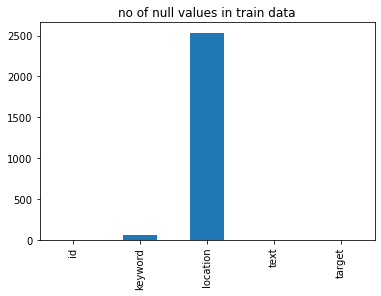

In [9]:
# Visualiser les NAN train
train_df.isna().sum().plot(kind="bar")
plt.title("no of null values in train data")
plt.show()

In [10]:
# drop location and keyword column
train_df = train_df.drop(['location','keyword'],axis=1)
test_df = test_df.drop(['location','keyword'],axis=1)

In [11]:
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
# finding percentage of 0 and 1 target
real_tweets = len(train_df[train_df["target"] == 1])
real_tweets_percentage = real_tweets/train_df.shape[0]*100
fake_tweets_percentage = 100-real_tweets_percentage

#print
print("Real tweets percentage: ",real_tweets_percentage)
print("Fake tweets percentage: ",fake_tweets_percentage)

Real tweets percentage:  42.96597924602653
Fake tweets percentage:  57.03402075397347


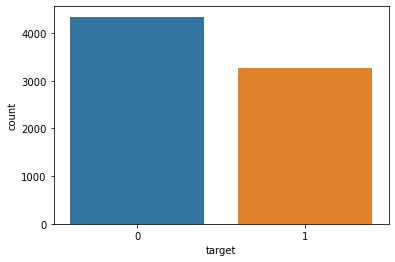

In [14]:
# plot of traget values
sns.countplot(x = 'target',
data = train_df) ;

In [15]:
# disaster tweets
disaster_tweets = train_df[train_df['target'] == 1 ]['text']
print(type(disaster_tweets))
print("------------------------")

for i in range(10):
    print(disaster_tweets[i])
disaster_tweets.shape

<class 'pandas.core.series.Series'>
------------------------
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...


(3271,)

In [16]:
# non-disaster tweets
non_disaster_tweets = train_df[train_df['target'] !=1 ]['text']

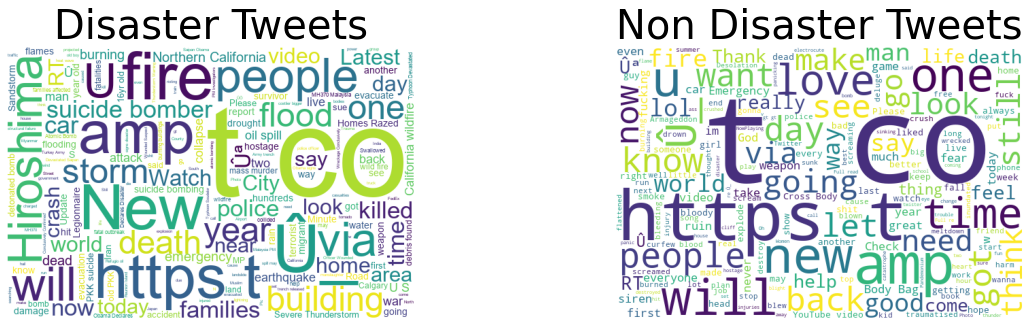

In [17]:
# word cloud of disaster and non-disaster tweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 5])


wordcloud1 = WordCloud( background_color = 'white',font_path="./arial.ttf",
width = 600,
height = 400).generate(" ".join(disaster_tweets))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize = 40);

wordcloud2 = WordCloud( background_color='white',
width=600,
height=400).generate(" ".join(non_disaster_tweets))

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [18]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,
remove punctuation
and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [19]:
# Applying the cleaning function to both test and train datasets
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))

# updated text
train_df.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in...,1
4,7,just got sent this photo from ruby alaska as s...,1


In [20]:
# Applying the cleaning function to both test and train datasets
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))

# updated text
train_df.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in...,1
4,7,just got sent this photo from ruby alaska as s...,1


In [21]:
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
train_df['text'] = train_df['text'].apply(lambda x:tokenizer.tokenize(x))
test_df['text'] = test_df['text'].apply(lambda x:tokenizer.tokenize(x))
train_df['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [22]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rossana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
print(stopwords.words('french'))
print("stopwords en français : ",len(stopwords.words('french')))

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [24]:
stopwords.words()

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [25]:
len(stopwords.words())

10405

In [26]:
# removing stopwords

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [27]:
train_df['text'] = train_df['text'].apply(lambda x : remove_stopwords(x))
test_df['text'] = test_df['text'].apply(lambda x : remove_stopwords(x))

In [28]:
# lemmatization

import nltk
nltk.download('wordnet')

lem = WordNetLemmatizer()

def lem_word(x):
    return [lem.lemmatize(w) for w in x]

[nltk_data] Downloading package wordnet to /Users/rossana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
train_df['text'] = train_df['text'].apply(lem_word)
test_df['text'] = test_df['text'].apply(lem_word)

In [30]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train_df['text'] = train_df['text'].apply(lambda x : combine_text(x))
test_df['text'] = test_df['text'].apply(lambda x : combine_text(x))
train_df['text']
train_df.head()

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la ronge sask canada,1
2,5,resident asked shelter place notified officer ...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo ruby alaska smoke wildfire pour...,1
